<img src ="../images/GatorGlaciologyLogo-01.jpg" width="100" align = "right">

# Interpolation with a trend
#### Gator Glaciology Lab, University of Florida

Geologic phenomena often have large-scale trends that override small-scale variability. As such, trends can make it difficult to model the variograms. As such, it is sometimes helpful to detrend the data prior to interpolation. The interpolation is then performed on the detrended data, and the interpolated result is added back to the trend.

<img src ="../images/detrending_schematic-01.jpg" width="800" align = "center">

Linear and polynomial trends are often used. However, we believe that non-parametric approaches are more versatile, especially for complex examples. Here we show how to use radial basis functions (RBFs) to estimate the trend. We uses this to perform kriging and SGS with a trend.

In [1]:
# load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from sklearn.preprocessing import QuantileTransformer 
import gstatsim as gs
import skgstat as skg
from skgstat import models
import random

# plotting utility functions
from plot_utils import splot2D, mplot1, make_colorbar

## Load and plot data

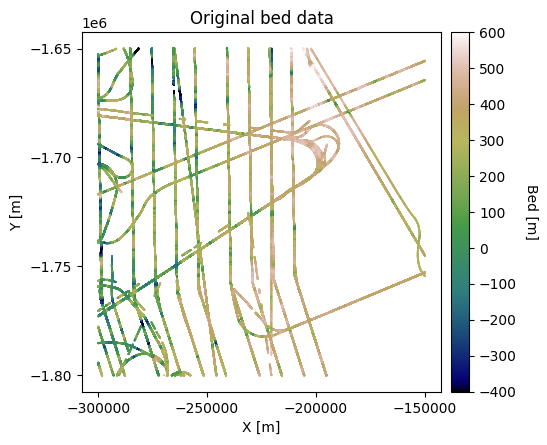

In [2]:
df_bed = pd.read_csv('data/greenland_test_data.csv') # download data
df_bed = df_bed[df_bed["Bed"] <= 700]  # remove erroneously high values, presumably due to bad bed picks

# plot original data
splot2D(df=df_bed, title='Original bed data')

## Grid data

In [3]:
# Grid data
res = 1000  # resolution
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res) # grid data
df_grid = df_grid[df_grid["Z"].isnull() == False]  # remove coordinates with NaNs
df_grid = df_grid.rename(columns = {"Z": "Bed"}) # rename column for consistency

## Compute trend

In [4]:
smooth_radius = 100000 # smoothing radius for RBF function (100 km)
trend_rbf = gs.rbf_trend(grid_matrix, smooth_radius, res)

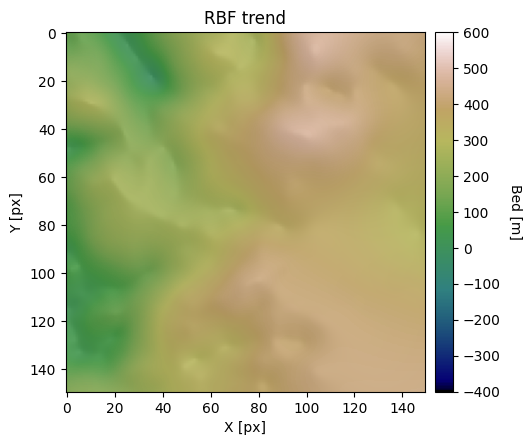

In [5]:
# Shade from the northeast, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=45, altdeg=45)

# leaving the dx and dy as 1 means a vertical exageration equal to dx/dy
hillshade = ls.hillshade(trend_rbf, vert_exag=1, dx=1, dy=1, fraction=1.0)

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(trend_rbf, vmin=-400, vmax=600, cmap='gist_earth')
ax.imshow(hillshade, cmap='gray', alpha=0.1)
ax.set_title('RBF trend')
ax.set_xlabel('X [px]'); ax.set_ylabel('Y [px]')
cbar = make_colorbar(fig, im, -400, 600, 'Bed [m]')
ax.axis('scaled')
plt.show()

## Compute residual from trend

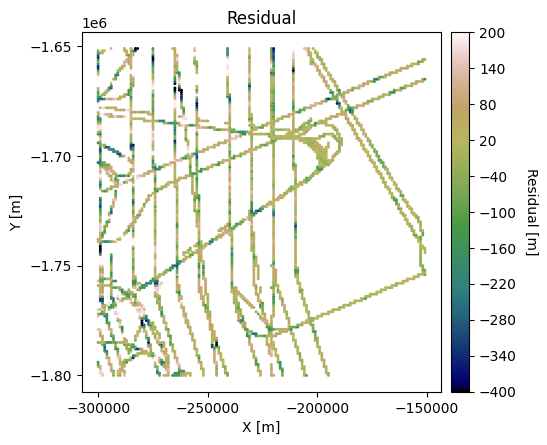

In [6]:
# subtract trend from data
diff = grid_matrix - trend_rbf
diff = np.flipud(diff) # flip matrix

# remove NaNs, add to dataframe
ny, nx = diff.shape
diff_array = np.reshape(diff,[ny*nx])
diff_array = diff_array[~np.isnan(diff_array)]
df_grid['Residual'] = diff_array

# plot residual 
splot2D(df=df_grid, title='Residual', c='Residual', vmin=-400, vmax=200, s=5, clabel='Residual [m]')

## Normal score transformation for residual data

In [7]:
data = df_grid['Residual'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid['Nres'] = nst_trans.transform(data) 

## Variogram analysis for residual data

In [8]:
# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nres']

maxlag = 50000 # maximum range distance
n_lags = 70 #num of bins

V1 = skg.Variogram(coords, values, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

V1.model = 'exponential' # use exponential variogram model

In [9]:
# set variogram parameters
vrange = V1.parameters[0]
vsill = V1.parameters[1]
vnugget = V1.parameters[2]

# evaluate models
xi =np.linspace(0, xdata[-1], 1000) 
y_exp = [models.exponential(h, vrange, vsill, vnugget) for h in xi]

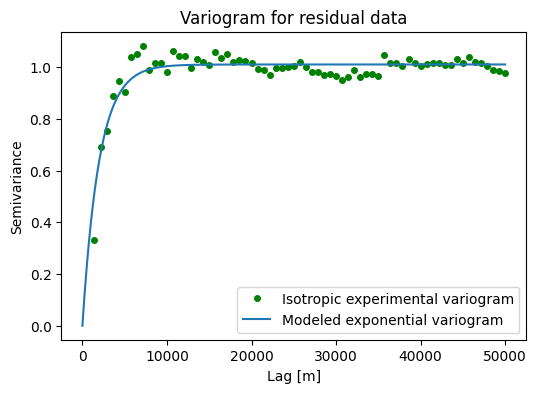

In [10]:
# plot variogram model
plt.figure(figsize=(6,4))
plt.plot(xdata, ydata, 'og', markersize=4, label='Isotropic experimental variogram')
plt.plot(xi, y_exp, '-', markersize=4, label='Modeled exponential variogram')
plt.title('Variogram for residual data')
plt.xlabel('Lag [m]'); plt.ylabel('Semivariance')  
plt.legend(loc='lower right')
plt.show()

The variogram sill here reaches 1, which makes sense because the variance of data with a standard Gaussian distribution should in theory be 1. In contrast, the variogram for the non-detrended data in Tutorial 2 (2_Variogram_model.ipynb) did not have a variogram of 1, which is a less desirable condition. As such, using the residual can lead to better variogram modeling, which makes the interpolation functions more effective.

## Initialize grid

Make list of grid cells that need to be simulated.

In [11]:
# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

## Kriging with a trend

Here will apply a kriging interpolation to the residual and add it to the trend. This procedure is known as kriging with a trend or universal kriging. Note that simple kriging should be used to krige the residual because the detrended data set has a constant mean.

In [12]:
# set variogram parameters
azimuth = 0
nugget = V1.parameters[2]

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0]
minor_range = V1.parameters[0]
sill = V1.parameters[1]
vario = [azimuth, nugget, major_range, minor_range, sill]

k = 100           # number of neighboring data points used to estimate a given point 
rad = 50000       # 50 km search radius

# est_SK is the estimate and var_SK is the variance
est_SK, var_SK = gs.Interpolation.skrige(Pred_grid_xy, df_grid, 'X', 'Y', 'Nres', k, vario, rad) 

100%|███████████████████████████████████████████████████████████████████████████| 22500/22500 [03:20<00:00, 112.21it/s]


In [13]:
# reverse normal score transformation
est = est_SK.reshape(-1,1)
spred_trans = nst_trans.inverse_transform(est)

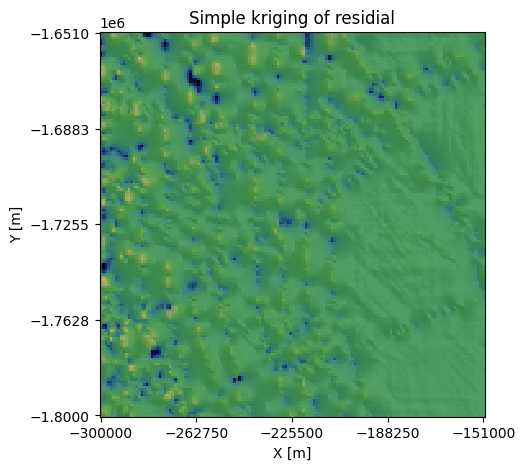

In [14]:
mplot1(Pred_grid_xy, spred_trans, rows, cols, title='Simple kriging of residial', hillshade=True)

Now let's add the trend:

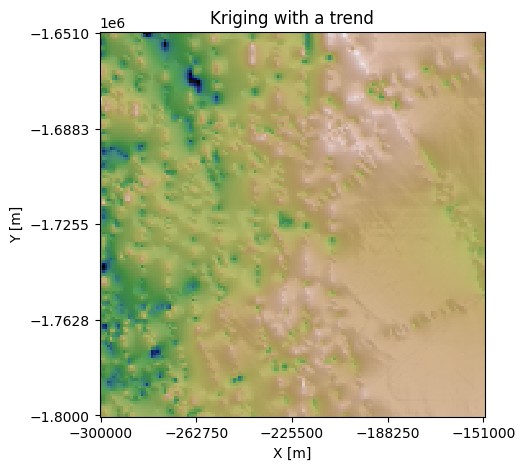

In [15]:
# add trend to kriging result
spred_mat = spred_trans.reshape((rows, cols))
sk_total = spred_mat + trend_rbf

mplot1(Pred_grid_xy, sk_total, rows, cols, title='Kriging with a trend', hillshade=True)

## Sequential Gaussian simulation

Now we will apply SGS to the residual. We will use the version of SGS that uses simple kriging.

In [16]:
sim = gs.Interpolation.skrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nres', k, vario, rad) 

100%|███████████████████████████████████████████████████████████████████████████| 22500/22500 [03:41<00:00, 101.46it/s]


In [17]:
# reverse normal score transformation
sim1 = sim.reshape(-1,1)
sim_trans = nst_trans.inverse_transform(sim1)

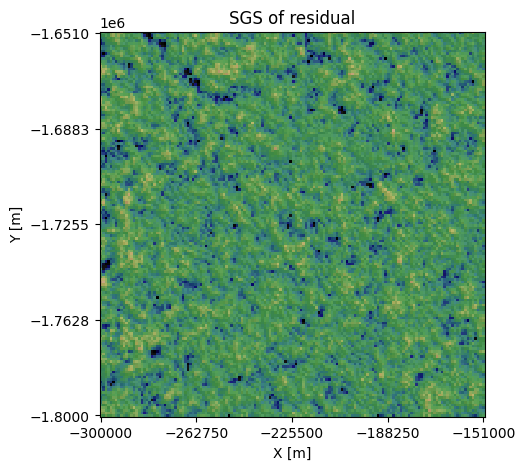

In [18]:
mplot1(Pred_grid_xy, sim_trans, rows, cols, title='SGS of residual', hillshade=True)

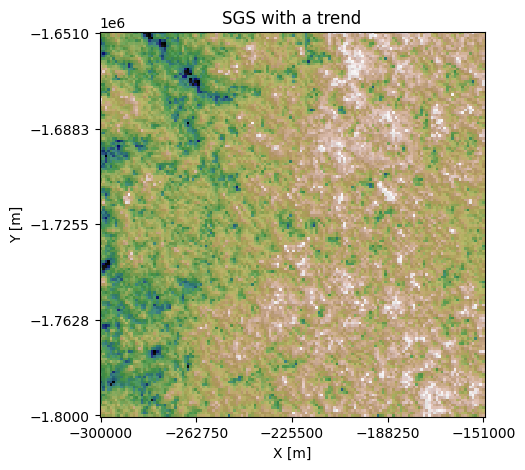

In [19]:
# add trend
sim_mat = sim_trans.reshape((rows, cols))
sgs_total = sim_mat + trend_rbf

mplot1(Pred_grid_xy, sgs_total, rows, cols, title='SGS with a trend', hillshade=True)

## Variogram analysis

Let's compare the variograms of the residual data and the SGS residual to assess simulation performance.

In [20]:
# compute SGS variogram
# downsample random indices to speed this up
rand_indices = random.sample(range(np.shape(Pred_grid_xy)[0]),5000)

# coordinates and values of simulated topography prior to back transormation
coords_s = Pred_grid_xy[rand_indices]
values_s = sim[rand_indices]

VS = skg.Variogram(coords_s, values_s, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)

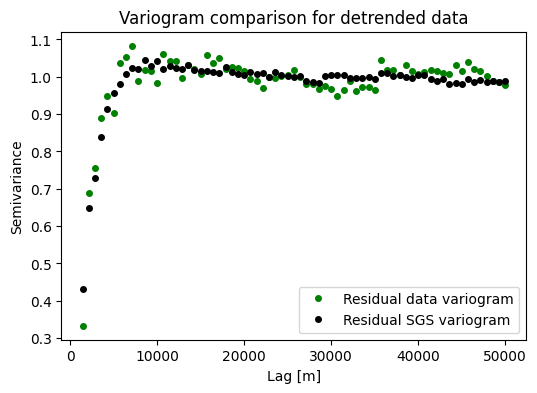

In [21]:
# plot variogram

# extract variogram values

# experimental variogram (from beginning of script)
xe = V1.bins
ye = V1.experimental

# simple kriging variogram
xs = VS.bins
ys = VS.experimental

plt.figure(figsize=(6,4))
plt.plot(xe, ye, 'og', markersize=4, label='Residual data variogram')
plt.plot(xs, ys, 'ok', markersize=4, label='Residual SGS variogram')
plt.title('Variogram comparison for detrended data')
plt.xlabel('Lag [m]'); plt.ylabel('Semivariance')
plt.legend(loc='lower right')
plt.show()

Compared to Tutorial 4 (4_Sequential_Guassian_Simulation.ipynb), the variograms have better agreement.